In [ ]:
# !pip install "protobuf==4.21.12" --force-reinstall

In [1]:
import json
from tqdm.auto import tqdm
import pickle
import functools
from transformers import AutoModelForCausalLM, AutoTokenizer, TextIteratorStreamer
import torch as t
from threading import Thread
from io import StringIO
# import circuitsvis as cv
from typing import List, Tuple
import numpy as np
import re
import gc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
# model_name = "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-1.5b/2"
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype = t.bfloat16,
    device_map = "auto",
    attn_implementation="eager"
)

In [3]:
device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

In [ ]:
# #based on the kurtosis scores
# receiver_heads = [(15,  7), (0,  8), (0,  0), (0,  6), (21,  5), (1,  3), (14,  8), (21,  2), (15, 11), (12,  8), (7,  2), (9,  2), (6,  6), (11, 11), (6,  2), (21,  3), (14,  7), (8,  4), (11,  1), (4,  9)]

In [4]:
#get the cots to visualize

records = []
with open("/content/cots.jsonl", "r", encoding = "utf-8") as f:
    for line in f:
        records.append(json.loads(line))

In [5]:
def get_sentence_token_boundaries(
    text: str, sentences: List[str]
) -> List[Tuple[int, int]]:
    """
    Get exact token boundaries for sentences within the full text.
    This accounts for tokenization effects where tokens may be different
    when sentences are tokenized together vs separately.

    Args:
        text: Full text containing all sentences
        sentences: List of sentence strings
        model_name: Model name for tokenizer

    Returns:
        List of (start, end) token positions for each sentence
    """
    if not sentences:
        return None

    import re

    def normalize_spaces(s: str) -> str:
        """Replace various Unicode spaces with regular space."""
        return re.sub(r"[\u00A0\u1680\u2000-\u200B\u202F\u205F\u3000\uFEFF]", " ", s)

    char_positions = []
    search_start = 0

    text_normalized = normalize_spaces(text)

    for sentence in sentences:
        sentence_normalized = normalize_spaces(sentence)

        norm_pos = text_normalized.find(sentence_normalized, search_start)
        if norm_pos == -1:
            sentence_stripped = sentence_normalized.strip()
            norm_pos = text_normalized.find(sentence_stripped, search_start)
            if norm_pos == -1:
                raise ValueError(f"Sentence not found in text: {sentence}")
            norm_end = norm_pos + len(sentence_stripped)
        else:
            norm_end = norm_pos + len(sentence_normalized)

        original_pos = 0
        normalized_count = 0
        actual_start = -1
        actual_end = -1

        for i, char in enumerate(text):
            if normalized_count == norm_pos and actual_start == -1:
                actual_start = i
            if normalized_count == norm_end:
                actual_end = i
                break
            if normalize_spaces(char) == " " or char == text_normalized[normalized_count]:
                normalized_count += 1

        if actual_end == -1 and normalized_count == norm_end:
            actual_end = len(text)

        char_positions.append((actual_start, actual_end))
        search_start = norm_end

    token_boundaries = []

    for char_start, char_end in char_positions:
        if char_start > 0:
            tokens_to_start = len(get_raw_tokens(text[:char_start]))
        else:
            tokens_to_start = 0

        tokens_to_end = len(get_raw_tokens(text[:char_end]))

        token_boundaries.append((tokens_to_start, tokens_to_end))

    return token_boundaries

In [6]:
def _compute_averaged_matrix(
    matrix: np.ndarray, sentence_boundaries: List[Tuple[int, int]]
) -> np.ndarray:
    """
    Helper function to compute averaged matrix from raw matrix and boundaries.

    Args:
        matrix: Raw attention matrix
        sentence_boundaries: List of (start, end) tuples for each sentence

    Returns:
        Averaged matrix where each cell (i,j) is the average attention
        from sentence i to sentence j
    """
    if sentence_boundaries is None:
        return matrix

    n = len(sentence_boundaries)
    result = np.zeros((n, n), dtype=np.float32)

    for i in range(n):
        row_start, row_end = sentence_boundaries[i]
        row_start = min(row_start, matrix.shape[0] - 1)
        row_end = min(row_end, matrix.shape[0] - 1)

        if row_start >= row_end:
            continue

        for j in range(n):
            col_start, col_end = sentence_boundaries[j]
            col_start = min(col_start, matrix.shape[1] - 1)
            col_end = min(col_end, matrix.shape[1] - 1)

            if col_start >= col_end:
                continue

            region = matrix[row_start:row_end, col_start:col_end]
            if region.size > 0:
                result[i, j] = np.mean(region)

    return result

In [15]:
def get_full_prompt(index):
    problem_str = records[index]["problem"]
    answer_str = records[index]["answer"]
    # answer_str = records[index]["cot"]
    full_prompt = (
        "<|User|>"
        + problem_str
        + "<|Assistant|><think>"
        + answer_str
    )

    return full_prompt

In [8]:
def get_raw_tokens(text: str) -> List[str]:
    """Convert text to raw tokens."""
    tokens_int = tokenizer.encode(text)
    tokens_words = tokenizer.convert_ids_to_tokens(tokens_int)
    return tokens_words

In [9]:
def split_solution_into_chunks(solution_text: str) -> List[str]:
    """
    Split a solution into chunks for rollout generation.

    Args:
        solution_text: The full solution text

    Returns:
        List of chunks
    """
    # First, remove the prompt part if present
    if "<think>" in solution_text:
        solution_text = solution_text.split("<think>")[1].strip()

    # Remove the closing tag if present
    if "</think>" in solution_text:
        solution_text = solution_text.split("</think>")[0].strip()

    # Define patterns for chunk boundaries
    sentence_ending_tokens = [".", "?", "!"]
    paragraph_ending_patterns = ["\n\n", "\r\n\r\n"]

    # Split the text into chunks
    chunks = []
    current_chunk = ""

    # Process the text character by character
    i = 0
    while i < len(solution_text):
        current_chunk += solution_text[i]

        # Check for paragraph endings
        is_paragraph_end = False
        for pattern in paragraph_ending_patterns:
            if (
                i + len(pattern) <= len(solution_text)
                and solution_text[i : i + len(pattern)] == pattern
            ):
                is_paragraph_end = True
                break

        # Check for sentence endings followed by space or newline
        is_sentence_end = False
        if i < len(solution_text) - 1 and solution_text[i] in sentence_ending_tokens:
            next_char = solution_text[i + 1]
            if next_char == " " or next_char == "\n":
                is_sentence_end = True

        # If we found a boundary, add the chunk and reset
        if is_paragraph_end or is_sentence_end:
            if current_chunk.strip():
                chunks.append(current_chunk.strip())
                current_chunk = ""

        i += 1

    # # Add the last chunk if not empty
    if current_chunk.strip():
        chunks.append(current_chunk.strip())
        # chunk_idxs.append(len(solution_text) - 1)  # Add last index

    # Merge small chunks (less than 10 characters)
    i = 0
    while i < len(chunks):
        if len(chunks[i]) < 10:
            # If this is the last chunk, merge with previous chunk if possible
            if i == len(chunks) - 1:
                if i > 0:
                    chunks[i - 1] = chunks[i - 1] + " " + chunks[i]
                    chunks.pop(i)
            # Otherwise merge with the next chunk
            else:
                chunks[i + 1] = chunks[i] + " " + chunks[i + 1]
                chunks.pop(i)
                # Don't increment i since we need to check the new merged chunk
            # If we're at the beginning and there's only one chunk, just keep it
            if i == 0 and len(chunks) == 1:
                break
        else:
            i += 1

    # chunk_boundaries = [(chunk_idxs[i], chunk_idxs[i + 1]) for i in range(len(chunk_idxs) - 1)]
    # chunk_boundaries.append((chunk_idxs[-1], len(solution_text)))

    # if get_idxs:
    #     return chunks, chunk_boundaries
    # else:
    return chunks

In [10]:
def get_chunk_ranges(full_text: str, chunks: List[str]) -> List[Tuple[int, int]]:
    # Get character ranges for each chunk in the full text
    chunk_ranges = []
    current_pos = 0

    for chunk in chunks:
        # Normalize the chunk for comparison (preserve length but standardize whitespace)
        normalized_chunk = re.sub(r"\s+", " ", chunk).strip()

        # Try to find the chunk in the full text
        chunk_start = -1

        # First try exact match from current position
        exact_match_pos = full_text.find(chunk, current_pos)
        if exact_match_pos != -1:
            chunk_start = exact_match_pos
        else:
            # If exact match fails, try with normalized text
            chunk_words = normalized_chunk.split()

            # Search for the sequence of words, allowing for different whitespace
            for i in range(current_pos, len(full_text) - len(normalized_chunk)):
                # Check if this could be the start of our chunk
                text_window = full_text[i : i + len(normalized_chunk) + 20]  # Add some buffer
                normalized_window = re.sub(r"\s+", " ", text_window).strip()

                if normalized_window.startswith(normalized_chunk):
                    chunk_start = i
                    break

                # If not found with window, try word by word matching
                if i == current_pos + 100:  # Limit detailed search to avoid performance issues
                    for j in range(current_pos, len(full_text) - 10):
                        # Try to match first word
                        if re.match(
                            r"\b" + re.escape(chunk_words[0]) + r"\b",
                            full_text[j : j + len(chunk_words[0]) + 5],
                        ):
                            # Check if subsequent words match
                            match_text = full_text[j : j + len(normalized_chunk) + 30]
                            normalized_match = re.sub(r"\s+", " ", match_text).strip()
                            if normalized_match.startswith(normalized_chunk):
                                chunk_start = j
                                break
                    break

        if chunk_start == -1:
            print(f"Warning: Chunk not found in full text: {chunk[:50]}...\n")
            print(full_text)
            continue

        # For the end position, find where the content of the chunk ends in the full text
        chunk_content = re.sub(r"\s+", "", chunk)  # Remove all whitespace
        full_text_from_start = full_text[chunk_start:]
        full_text_content = re.sub(
            r"\s+", "", full_text_from_start[: len(chunk) + 50]
        )  # Remove all whitespace

        # Find how many characters of content match
        content_match_len = 0
        for i in range(min(len(chunk_content), len(full_text_content))):
            if chunk_content[i] == full_text_content[i]:
                content_match_len += 1
            else:
                break

        # Map content length back to original text with whitespace
        chunk_end = chunk_start
        content_chars_matched = 0
        for i in range(len(full_text_from_start)):
            if chunk_end + i >= len(full_text):
                break
            if not full_text[chunk_start + i].isspace():
                content_chars_matched += 1
            if content_chars_matched > content_match_len:
                break
            chunk_end = chunk_start + i

        chunk_end += 1  # Include the last character
        current_pos = chunk_end

        chunk_ranges.append((chunk_start, chunk_end))

    return chunk_ranges

In [11]:
def split_solution_keep_spacing(solution_text: str) -> List[str]:
    """
    Split a solution into chunks while preserving spacing.
    """
    # Define patterns for chunk boundaries
    sentences = split_solution_into_chunks(solution_text)
    chunk_ranges = get_chunk_ranges(solution_text, sentences)
    sentences_w_spacing = [
        solution_text[chunk_range[0] : chunk_range[1]] for chunk_range in chunk_ranges
    ]
    return sentences_w_spacing

In [12]:
def get_all_avg_attention_matrices(index, receiver_heads, scale: int = 0, n_heads: int = 12, proximity_ignore:int = 4, control_depth: bool = False, score_type:str = "mean"):
    full_prompt = get_full_prompt(index)
    sentences = split_solution_keep_spacing(full_prompt)

    input_ids = tokenizer(full_prompt, return_tensors="pt", add_special_tokens=False).to(device)
    attn_scores_cache = {}
    sentence_boundaries = get_sentence_token_boundaries(full_prompt, sentences)
    def analysis_hook(module, input, output, layer_idx, head_idx):
        """
        Hook to intercept attention weights, compute stats, and discard weights. This is for a single input
        """
        if output[1] is None:
            print("Didn't get attention outputs")
            return

        attn_matrix = output[1][0].detach().cpu().float().numpy()

        if scale:
            attn_matrix *= scale
            print("Scaled")

        avg_mat = _compute_averaged_matrix(attn_matrix[head_idx], sentence_boundaries)
        attn_scores_cache[f"L{layer_idx} H{head_idx}"] = avg_mat

        del attn_matrix

    hooks = []
    for layer, head in receiver_heads:
        model.model.layers[layer].self_attn.output_attentions = True
        hook = model.model.layers[layer].self_attn.register_forward_hook(
            functools.partial(analysis_hook, layer_idx = layer, head_idx = head)
        )
        hooks.append(hook)
    try:
        with t.inference_mode():
           model(**input_ids, output_attentions=False)

    except Exception as e:
            print(f"Error during forward pass: {e}")
            raise e
    finally:
        for h in hooks:
            h.remove()

        for layer in model.model.layers:
            layer.self_attn.output_attentions = False

        t.cuda.empty_cache()
        gc.collect()

    return attn_scores_cache, sentences

In [16]:
#get the amplified cots
records= []
with open("/content/evals_scale_1.5_pruned_new.jsonl", "r", encoding = "utf-8") as f:
    for line in f:
        records.append(json.loads(line))

In [13]:
#based on the above, the top receiver heads

#top-2
pruned_receiver_heads_top2 = [(21, 5), (21, 2)]

In [18]:
attention_head_names = [f"L{layer} H{head}" for layer,head in pruned_receiver_heads_top2]

In [ ]:
#top5
# pruned_receiver_heads_top5 = [(21, 5), (21, 2), (7, 2), (6, 2), (21, 3)]

In [19]:
d_head = model.config.hidden_size // model.config.num_attention_heads

In [20]:
def get_attn_matrices_after_boosting(index, pruned_receiver_heads_top2, scale):
    def scale_receiver_heads_hook(module, input, head_idx):
        full_attn_matrix = input[0].clone()  #removes the batch dim
        b, s, h = full_attn_matrix.shape
        reshaped_attn_matrix = full_attn_matrix.view(b, s, -1, d_head)
        reshaped_attn_matrix[:, :, head_idx, :] *= scale
        return (reshaped_attn_matrix.view(b, s, -1),)


    hooks = []
    try:
        for layer, head in pruned_receiver_heads_top2:
            hook = model.model.layers[layer].self_attn.o_proj.register_forward_pre_hook(
                functools.partial(scale_receiver_heads_hook, head_idx = head)
            )
            hooks.append(hook)

        return get_all_avg_attention_matrices(index, pruned_receiver_heads_top2, scale = scale)

    except Exception as e:
        print(f"Error occured: {e}")

    finally:
        for hook in hooks:
            hook.remove()


In [21]:
all_attn_cache_boosted_0, sentences_0 = get_attn_matrices_after_boosting(0, pruned_receiver_heads_top2, 1.5)

Scaled
Scaled


In [23]:
stacked_attention_0 = np.stack([all_attn_cache_boosted_0[f"L{l} H{h}"] for l, h in pruned_receiver_heads_top2])

In [24]:
matrix_0_1 = all_attn_cache_boosted_0[f"L{pruned_receiver_heads_top2[0][0]} H{pruned_receiver_heads_top2[0][1]}"]
matrix_0_2 = all_attn_cache_boosted_0[f"L{pruned_receiver_heads_top2[1][0]} H{pruned_receiver_heads_top2[1][1]}"]

In [19]:
def plot_sentence_attention_clean(
    attn_matrix,
    sentences,
    quantile=0.99,
    cmap="Blues",
    x_label_frequency=4 # Suggested default: every 4th index
):
    assert attn_matrix.shape[0] == attn_matrix.shape[1]
    assert attn_matrix.shape[0] == len(sentences)

    N = attn_matrix.shape[0]
    # Use a high quantile to handle outliers and make the map readable
    vmax = np.nanquantile(attn_matrix, quantile)

    # Slightly adjust figure size ratio if it's very long
    fig, ax = plt.subplots(figsize=(12, 10))

    im = ax.imshow(
        attn_matrix,
        vmin=0,
        vmax=vmax,
        cmap=cmap,
        origin="upper",
        aspect='equal' # Ensure cells are square
    )

    ax.set_xlabel("Key sentence index (x)", fontsize=12, labelpad=10)
    ax.set_ylabel("Query sentence index (y)", fontsize=12, labelpad=10)
    ax.set_title(f"Sentence-level Attention (N={N})", fontsize=14, pad=20)

    # --- Axis Labeling Logic ---
    indices = np.arange(0, N)
    labels = [str(i) for i in indices]

    # Filter based on frequency
    display_indices = [i for i in indices if i % x_label_frequency == 0]
    display_labels = [labels[i] for i in display_indices]

    # X-Axis setup
    ax.set_xticks(display_indices)
    # Rotate 90 degrees for clean vertical alignment
    ax.set_xticklabels(display_labels, rotation=90, ha="center", fontsize=9)

    # Y-Axis setup (mirrors X-axis for symmetry)
    ax.set_yticks(display_indices)
    ax.set_yticklabels(display_labels, fontsize=9)

    # --- Cleanup Visuals ---
    # Add faint gridlines to guide the eye
    ax.grid(which="major", color="grey", linestyle='-', linewidth=0.5, alpha=0.2)

    # Remove the tick marks themselves for a cleaner look
    ax.tick_params(axis='both', which='both', length=0)

    # Ensure x-ticks are at bottom
    ax.xaxis.tick_bottom()


    # --- Interactive Click Section (Unchanged) ---
    marker, = ax.plot([], [], "ro", markersize=6, markeredgecolor='white')

    def onclick(event):
        if event.inaxes != ax:
            return
        # Ensure click is within bounds before casting to int
        if event.xdata is None or event.ydata is None:
            return

        x = int(round(event.xdata))
        y = int(round(event.ydata))

        if 0 <= x < N and 0 <= y < N:
            value = attn_matrix[y, x]
            marker.set_data([x], [y]) # Pass as sequences
            fig.canvas.draw_idle()

            print("\n" + "-" * 80)
            print(f"Clicked cell [y={y}, x={x}]")
            print(f"  Attention Value = {value:.6f}")
            print("-" * 30)
            print(f"Query [y={y}]: {sentences[y]}")
            print("-" * 5)
            print(f"Key   [x={x}]: {sentences[x]}")
            print("-" * 80)

    cid = fig.canvas.mpl_connect("button_press_event", onclick)

    # Add colorbar with appropriate labeling
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

For L21 H5

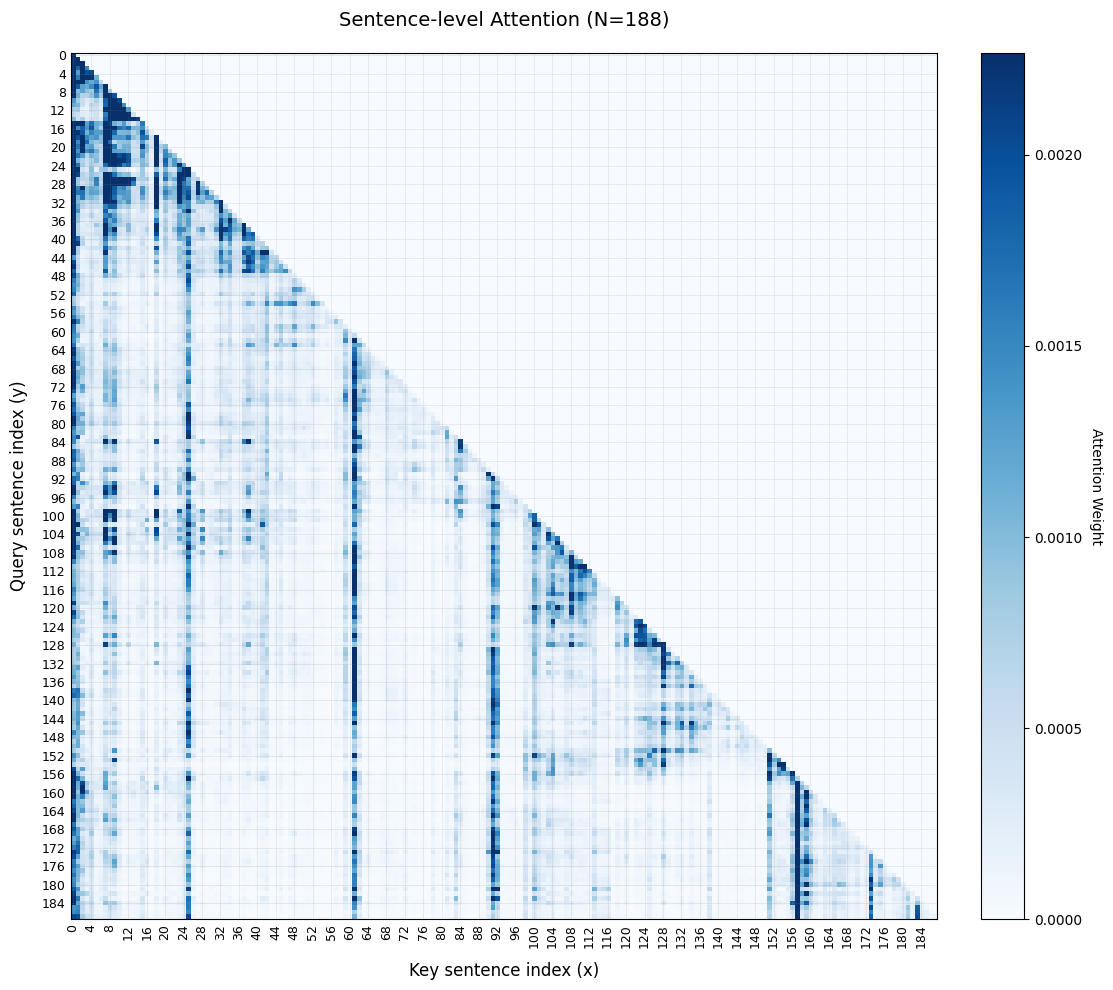

In [43]:
plot_sentence_attention_clean(
    attn_matrix=matrix_0_1,
    sentences=sentences_0,
)


In [59]:
sentences_0[50:70]

['Compute 0.005 * 1.005: 0.005 + 0.000025 = 0.005025\n\n',
 'So, total is 1.005 + 0.005025 = 1.010525\n\n',
 'So, (1.005)^2 = 1.010525\n\n',
 'Now, compute (1.010525)^6.\n\n',
 'Because 12 is 2*6.\n\n',
 'Compute (1.010525)^2: 1.010525 * 1.010525.\n\n',
 'Compute 1 * 1.010525: 1.010525\n\n',
 'Compute 0.010525 * 1.010525: Approximately, 0.011716.\n\n',
 'So, total is approximately 1.010525 + 0.011716 = 1.0232331\n\n',
 'So, (1.005)^2 = 1.010525\n\n',
 "Wait, that's (1.005)^2, which is 1.010025? ",
 'Wait, maybe I miscalculated.\n\n',
 "Wait, let's be precise.\n\n",
 'Compute (1.005)^2:\n\n',
 '1.005 * 1.005.\n\n',
 'First, 1 * 1.005 = 1.005\n\n',
 'Then, 0.005 * 1.005 = 0.005025\n\n',
 'So, adding them: 1.005 + 0.005025 = 1.010525\n\n',
 'So, (1.005)^2 = 1.010025\n\n',
 'Wait, no, 1.005^2 is 1.005 + 0.005025 = 1.10025, which is 1.10025.\n\n']

In [61]:
x = "rule of 72"
indices = [i for i, s in enumerate(sentences_0) if x in s]

print(indices)

[104]


In [48]:
sentences_0[24:28]

['EAR_monthly = P * (1 + 0.06/12)^(12*1)\n\n',
 'Wait, hold on. ',
 'Let me make sure I get that right.\n\n',
 'The formula is:\n\n']

In [49]:
sentences_0[60:64]

["Wait, that's (1.005)^2, which is 1.010025? ",
 'Wait, maybe I miscalculated.\n\n',
 "Wait, let's be precise.\n\n",
 'Compute (1.005)^2:\n\n']

In [50]:
sentences_0[90:93]

['Then, we have to compute (1.010025)^6.\n\n',
 "Wait, no, let's think.\n\n",
 'Wait, no, sorry, I think I made a confusion.\n\n']

In [56]:
sentences_0[100:104]

['(1 + x)^n ≈ e^(nx), but that might not be precise.\n\n',
 'Wait, actually, perhaps I can compute 1.005^12 using logarithms.\n\n',
 "Wait, but that's a bit involved.\n\n",
 'Alternatively, maybe I can compute 1.005^12 using the formula for compound interest.\n\n']

For L21 H2

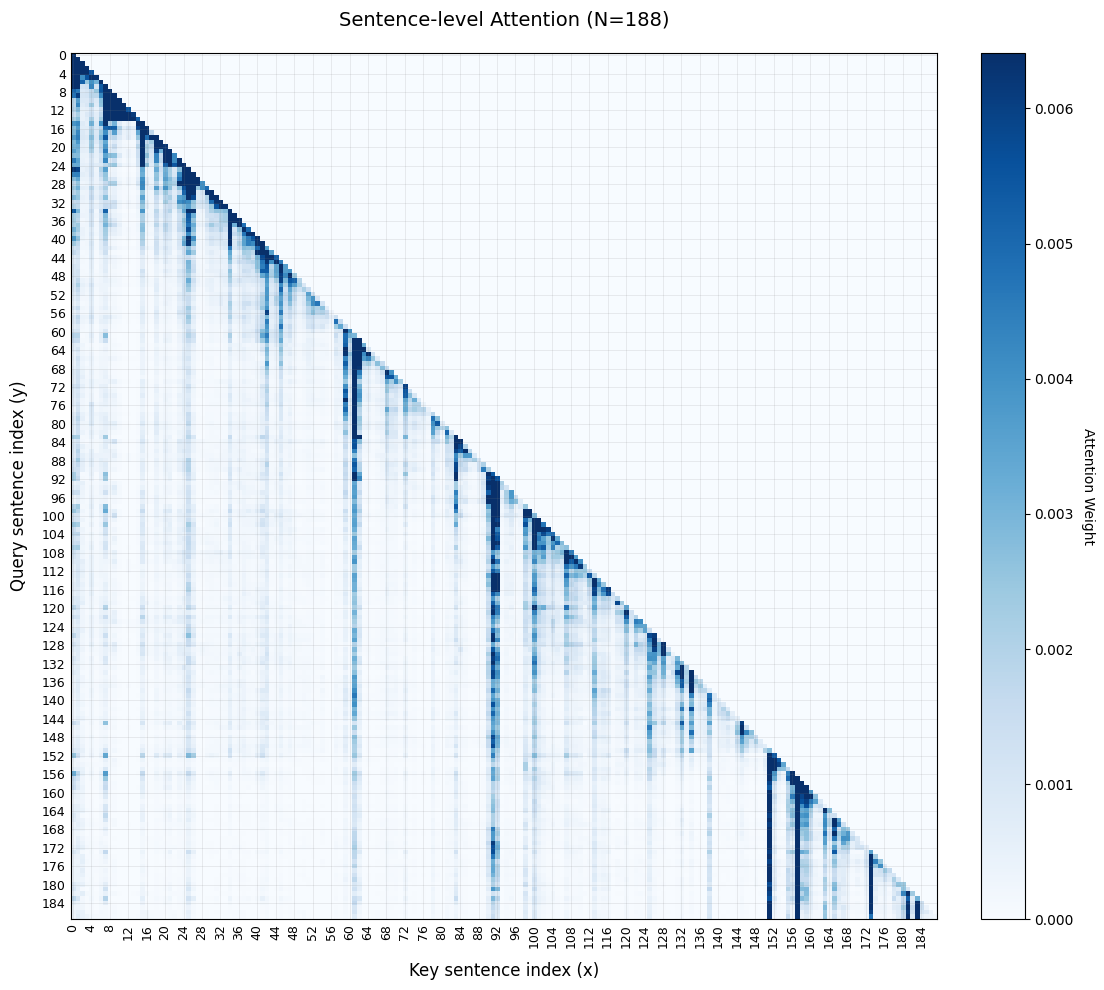

In [51]:
plot_sentence_attention_clean(
    attn_matrix=matrix_0_2,
    sentences=sentences_0,
)


In [53]:
sentences_0[148:153]

['1.45985 + 0.0117571125 ≈ 1.4716071125\n\n',
 '1.4716071125 + 0.003591666 ≈ 1.48520868\n\n',
 '1.48520868 + 0.0000727 ≈ 1.4853008\n\n',
 'So, e^0.05985 ≈ 1.4853\n\n',
 "Wait, but that's approximate.\n\n"]

In [54]:
sentences_0[156:161]

['Wait, let me check with calculator.\n\n',
 "But, since I can't use a calculator, perhaps I can think differently.\n\n",
 'Wait, actually, maybe I can compute 1.005^12 more accurately.\n\n',
 'Alternatively, perhaps I can think in terms of monthly compounding.\n\n',
 'So, 1.005^12.\n\n']

['Wait, (1.005)^12 is 1.010525, which is 1.010025.\n\n',
 'Then, (1.010025)^6 is equal to (1.010025)^6.\n\n',
 "Wait, perhaps it's better to compute (1.010025)^6.\n\n",
 'But 1.010025^1 is 1.010025\n\n']